# Kernels
In machine learning, kernel methods are a class of algorithms for pattern analysis, whose best known member is the support vector machine (SVM). The general task of pattern analysis is to find and study general types of relations (for example clusters, rankings, principal components, correlations, classifications) in datasets. For many algorithms that solve these tasks, the data in raw representation have to be explicitly transformed into feature vector representations via a user-specified feature map: in contrast, kernel methods require only a user-specified kernel, i.e., a similarity function over pairs of data points in raw representation.
Kernel methods owe their name to the use of kernel functions, which enable them to operate in a high-dimensional, implicit feature space without ever computing the coordinates of the data in that space, but rather by simply computing the inner products between the images of all pairs of data in the feature space. This operation is often computationally cheaper than the explicit computation of the coordinates. This approach is called the "kernel trick".
Kernel functions have been introduced for sequence data, graphs, text, images, as well as vectors.

In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample

## Objective 
Maximaize $f2$ score, also try $f=0.5$


In [18]:
begin = time.time()

#Load dataset and split into X and y
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

print(X.shape)
print('The portion of ' + cancer.target_names[1] + ' cancer: ' + str(round(y.sum()/len(y) * 100, 4)) + '%.')
# Rest is malignant
# The dataset is quite balanced.
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

(569, 30)
The portion of benign cancer: 62.7417%.


In [19]:
# Convert to df and get some info
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
#df.info()
#df.describe()

# Split into train and test set and normalize data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2) #, random_state = 0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

fbeta_score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

$f1$ and $f2$ scores: https://en.wikipedia.org/wiki/F1_score

$F_\beta=(1+\beta^2)\cdot \frac{precision  \cdot  recall}{\beta^2 \cdot precision + recall} = \frac{1+\beta^2}{\frac{1}{precision}+\frac{\beta^2}{recall}}$

Now $\beta=2$ for $f2$, the score weighs recall higher than precision by placing more emphasis on false negatives. In this case, we want to be more confident of predicting benign cancer more precisely and want to diagnose less a benign cancer as malignant, i.e. to avoid false negative of benign cancer.

We will consider $f=0.5$ as well:
If we want to avoid false positives, we need to maximize Precision or put more weights on precision in the $f_\beta$ score if we want to balance recall and precision as well. 
Therefore, as a second objective, we pick $\beta = 0.5$ to get $f0.5$ and use it as our optimization object for this question.

In [20]:
# fixed: make f2 a valid validation
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 2, pos_label = 0, average = 'binary')

f2 = make_scorer(f2_scorer, greater_is_better=True)

# here for question b: make f05 a valid validation
def f05_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta = 0.5, pos_label = 0, average = 'binary')

f05 = make_scorer(f05_scorer, greater_is_better = True)

We first make the graphs to illustrate the relationships between hyperparameters and f2 and f0.5 scores for polynomial and rbf kernels. 

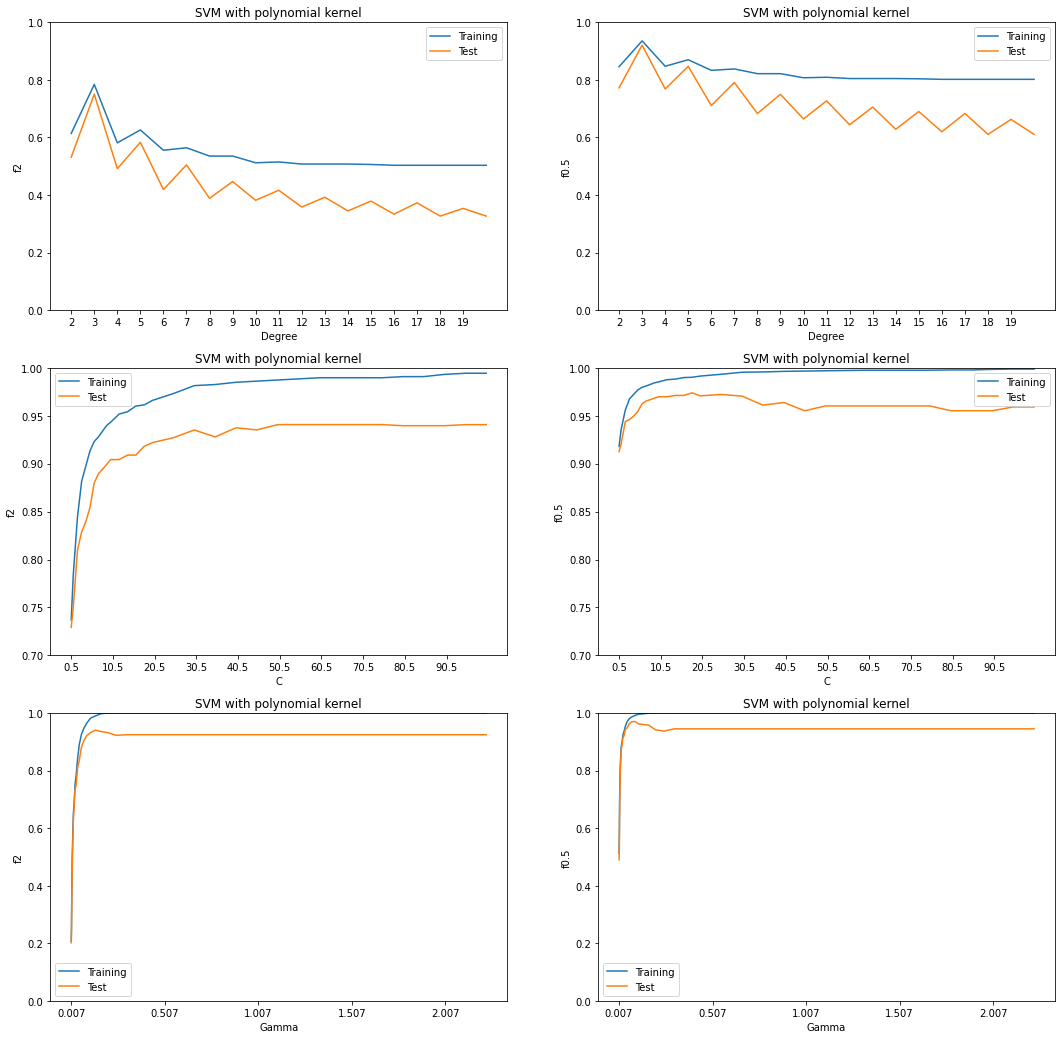

In [21]:
# SVM with polynomial kernel
# for score = f2 and f0.5
# hyperparameters gamma, C and degree, degree is the main one
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
#
def plot_poly_curve(gammas = 'auto', Cs = 1, degrees = 3, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(degrees) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, C = Cs) # here C is fixed
        num_values = len(degrees)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "degree", degrees, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Degree'
        xtick = np.arange(degrees.min(), degrees.max(), 1)
        Xs = degrees
        ylim = [0, 1]
    elif type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', gamma = gammas, degree = degrees)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "C", Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'poly', degree = degrees, C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "gamma", gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 18))
degrees = np.arange(2, 21, 1) # choose/scan more systematically 
Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(3, 2, 1)
plot_poly_curve(degrees = degrees)
plt.subplot(3, 2, 2)
plot_poly_curve(degrees = degrees, scoring = f05)
plt.subplot(3, 2, 3)
plot_poly_curve(Cs = Cs)
plt.subplot(3, 2, 4)
plot_poly_curve(Cs = Cs, scoring = f05)
plt.subplot(3, 2, 5)
plot_poly_curve(gammas = gammas)
plt.subplot(3, 2, 6)
plot_poly_curve(gammas = gammas, scoring = f05)

plt.show()

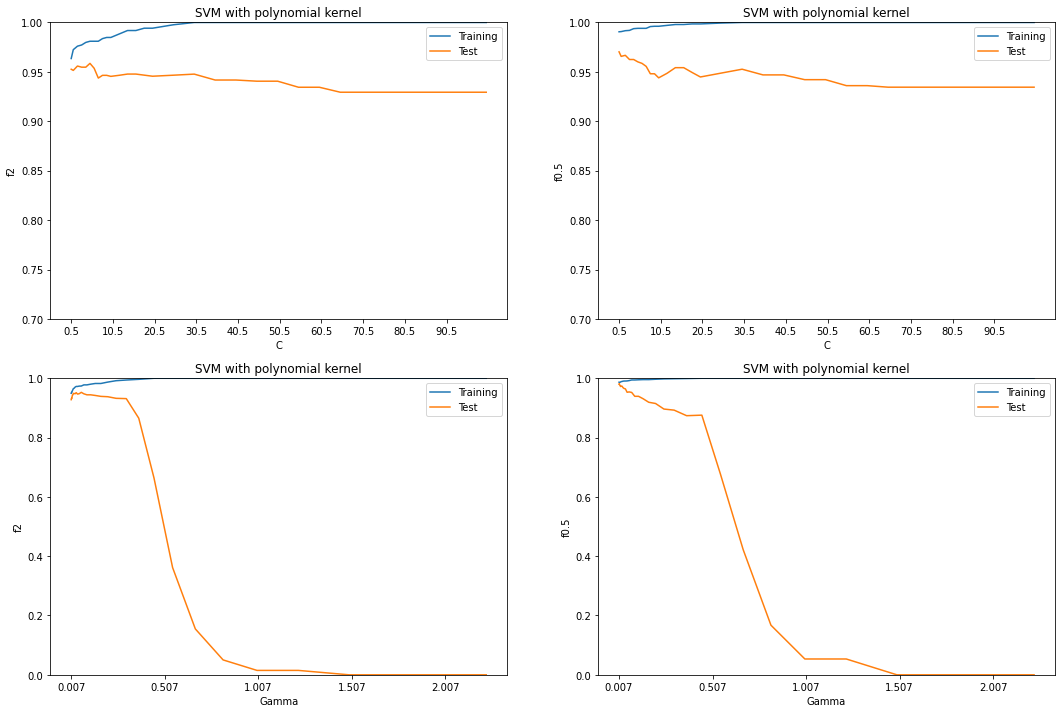

In [22]:
# The two functions can actually be integrated.
def plot_rbf_curve(gammas = 'auto', Cs = 1, scoring = f2): # by default
    
    num_splits = 5 # use of k-fold is good
    kfold = KFold(n_splits = 5) # ,random_state = 0) 
    
    if type(Cs) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', gamma = gammas)
        num_values = len(Cs)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "C", Cs, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'C'
        xtick = np.arange(Cs.min(), Cs.max(), 10)
        Xs = Cs
        ylim = [0.7, 1]
    elif type(gammas) == np.ndarray:
        svm_poly = svm.SVC(kernel = 'rbf', C = Cs)
        num_values = len(gammas)
        train_scores, valid_scores = validation_curve(svm_poly, X_train, y_train, 
                                                  "gamma", gammas, cv=kfold, 
                                                  scoring = scoring)
        xlabel = 'Gamma'
        xtick = np.arange(gammas.min(), gammas.max(), 0.5)
        Xs = gammas
        ylim = [0, 1]
    else:
        raise TypeError

    train_scores_poly = pd.DataFrame(data = train_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 
    valid_scores_poly = pd.DataFrame(data = valid_scores, 
                                        index = np.arange(0, num_values), 
                                        columns = np.arange(0, num_splits)) 

    plt.plot(Xs, train_scores_poly.mean(axis=1), label = 'Training')
    plt.plot(Xs, valid_scores_poly.mean(axis=1), label = 'Test')
    plt.xlabel(xlabel)
    if scoring == f2:
        plt.ylabel('f2')
    elif scoring == f05:
        plt.ylabel('f0.5')
    else:
        plt.ylabel('scoring')
    plt.ylim(ylim)
    plt.xticks(xtick)
    plt.title('SVM with polynomial kernel')
    plt.legend()

    
plt.figure(figsize = (18, 12))

Cs = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))
#gammas = np.arange(0.008, 0.051, 0.002)
gammas = np.exp(np.arange(-5, 1, 0.2))

plt.subplot(2, 2, 1)
plot_rbf_curve(Cs = Cs)
plt.subplot(2, 2, 2)
plot_rbf_curve(Cs = Cs, scoring = f05)
plt.subplot(2, 2, 3)
plot_rbf_curve(gammas = gammas)
plt.subplot(2, 2, 4)
plot_rbf_curve(gammas = gammas, scoring = f05)

plt.show()

The rbf kernel generally performs much better in different hyperparameter combos, note that the y-axis in graphs for rbf kernel are ranging from 0.7 to 1, while that for polynomial kernel are ranging from 0 to 1. For the polynomial kernel, the higher the polynomial degree, the lower the scores. We can see sawtooth on the curve when degree changes, this might be that the tail directions of decision boundry will be the same for kernels using even order of degrees. 

For both kernels, the models perform not so well when C is very small (high degree of regularization), while a larger C (less regularization) will introduce overfitting: high score in training data but low in test data. Besides, the results generally get better with increasing gamma at the very beginning, all else equal, but become dramatically worse when gamma keeps increasing. This can be explained and illustrated under https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html. 

"Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors." Thus the classifier becomes extremly overfitted when gamma is large.

# Optimal hyperparameters
We use the GridSearchCV function to find the optimal hyperparameters in this part. In the Grid Search space, if gamma = 'scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma. Now training data is normalized, so gamma will be close to 1 / 30 = 0.0333 (depends on cross validation set) when gamma is defined by 'scale'. If gamma = ‘auto’, it uses 1 / n_features. Hence there is almost no difference between those two. We just use 1 / n_features and other specific values.

In [23]:
start = time.time()

param_grid = {'kernel' : ['poly', 'rbf', 'linear', 'sigmoid'],
              'C' : [0.001, 0.01, 0.1, 0.5, 1, 10, 50, 100],
              'gamma' : [1/X_train.shape[1], 0.01, 0.1, 1, 10],
              'degree' : [2, 3, 4, 5, 7, 10]}              

scoring = {'Accuracy' : 'accuracy',
           'Precision' : 'precision', 
           'recall' : 'recall',
           'f1' : 'f1', 
           'f2' : f2,
           'f0.5' : f05}

svm_ = svm.SVC() #random_state = 0)
CV_svm = GridSearchCV(estimator = svm_, param_grid = param_grid, cv = 5, 
                      scoring = scoring, refit = 'f2')
CV_svm.fit(X_train, y_train)


time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  44.5024938583374


In [24]:
# a DataFrame to keep track of the results
params_ = CV_svm.cv_results_['params']
result = {k : [dic[k] for dic in params_] for k in params_[0]}
cln = ['kernel', 'C', 'gamma', 'degree']

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result['mean_test_' + i] = CV_svm.cv_results_['mean_test_' + i]
    result['std_test_' + i] = CV_svm.cv_results_['std_test_' + i]
    cln.append('mean_test_' + i)

results = pd.DataFrame(result)
#display(results)

In [25]:
results.loc[results.kernel == 'linear', ['degree', 'gamma']] = np.nan
results.loc[results.kernel == 'rbf', 'degree'] = np.nan
results.loc[results.kernel == 'sigmoid', 'degree'] = np.nan

results.drop_duplicates(inplace = True) 
results_sorted2 = results.sort_values('mean_test_f2', ascending = False)
display(results_sorted2.loc[:,cln].head(10))
#display(results_sorted2.tail(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
602,linear,10.0,NaN,NaN,0.978022,0.982512,0.982393,0.982300,0.970960,0.971352
482,linear,1.0,NaN,NaN,0.982418,0.979474,0.992982,0.986053,0.969381,0.983383
362,linear,0.5,NaN,NaN,0.980220,0.979474,0.989474,0.984252,0.968225,0.978992
722,linear,50.0,NaN,NaN,0.967033,0.978753,0.968170,0.973353,0.961759,0.951953
725,rbf,50.0,0.010000,NaN,0.973626,0.975971,0.982393,0.978908,0.961220,0.968818
605,rbf,10.0,0.010000,NaN,0.978022,0.972813,0.992982,0.982666,0.959788,0.980624
842,linear,100.0,NaN,NaN,0.962637,0.978753,0.961153,0.969652,0.959487,0.943738
845,rbf,100.0,0.010000,NaN,0.969231,0.976006,0.975251,0.975266,0.958931,0.960105
242,linear,0.1,NaN,NaN,0.975824,0.972813,0.989474,0.980864,0.958632,0.976233
361,rbf,0.5,0.033333,NaN,0.971429,0.969521,0.985902,0.977351,0.952784,0.970478


We can see that the top ten mean f2 score from Cross Validation are dominated by Gaussian Kernel (rbf) and linear kernel (which is not required), relatively small gamma (0.01 to 1 / number of features) and large C (larger than 1, means less regularization). Therefore, it seems that C plays most important role in this training. A random search might be helpful.

Note that for linear kernel, gamma doesn't matter. Besides, degree works only for polynomial kernel. Therefore, duplicated values are removed.


In [26]:
results_sorted05 = results.sort_values('mean_test_f0.5', ascending = False)
results_sorted05.drop_duplicates(subset = results_sorted05.columns[3:], inplace = True) 
  
display(results_sorted05.loc[:,cln].head(10))

,kernel,C,gamma,degree,mean_test_Accuracy,mean_test_Precision,mean_test_recall,mean_test_f1,mean_test_f2,mean_test_f0.5
482,linear,1.000,NaN,NaN,0.982418,0.979474,0.992982,0.986053,0.969381,0.983383
122,linear,0.010,NaN,NaN,0.969231,0.953532,1.000000,0.976034,0.933479,0.982174
487,sigmoid,1.000,0.01,NaN,0.969231,0.953532,1.000000,0.976034,0.933479,0.982174
605,rbf,10.000,0.01,NaN,0.978022,0.972813,0.992982,0.982666,0.959788,0.980624
362,linear,0.500,NaN,NaN,0.980220,0.979474,0.989474,0.984252,0.968225,0.978992
485,rbf,1.000,0.01,NaN,0.967033,0.953588,0.996491,0.974265,0.932397,0.977554
242,linear,0.100,NaN,NaN,0.975824,0.972813,0.989474,0.980864,0.958632,0.976233
367,sigmoid,0.500,0.01,NaN,0.958242,0.938260,1.000000,0.967832,0.909006,0.974982
365,rbf,0.500,0.01,NaN,0.962637,0.947139,0.996491,0.970936,0.922798,0.974559
32,poly,0.001,1.00,3.0,0.964835,0.952762,0.992920,0.972322,0.931654,0.973026


The top ten mean $f_{0.5}$ score from Cross Validation are dominated again by Gaussian Kernel (rbf) and linear kernel. It seems that these two kernels work the best for this data. Here, small gamma at 0.01 and not very large C (0.5 to 10). C still plays a role in the model.

Again, since polynomial and sigmoid kernel do not perform well in this case, we use rbf kernel only and do the Grid Search again but within the approximate range we observed above to maximize the object and visualize the relationships between gamma, C and f2 score (optional f0.5 can be done similarly but is skipped here) in a 3D space. Here, we use the GridSearch instead of RandomSearch for an easier and more readable plotting later.

In [27]:
start = time.time()

C2 = np.append(np.array([0.5]), 
               np.append(np.append(np.arange(1, 10, 1), 
                                  
                                   np.arange(10, 20, 2)), 
                         np.arange(20, 101, 5)))

param_grid2 = {'C' : C2,
               'gamma' : np.append(np.arange(0.008, 0.051, 0.002), 1/X_train.shape[1])}   

svm_2 = svm.SVC(kernel = 'rbf', random_state = 0)
CV_svm2 = GridSearchCV(estimator = svm_2, param_grid = param_grid2, cv = 5, 
                       scoring = scoring, refit = 'f2')
CV_svm2.fit(X_train, y_train)

time_spend = time.time() - start
print('time spent: ', time_spend)

time spent:  26.645882844924927


In [28]:
# a DataFrame to keep track of the results
params_2 = CV_svm2.cv_results_['params']
result2 = {k : [dic[k] for dic in params_2] for k in params_2[0]}

for i in ['Accuracy', 'Precision', 'recall', 'f1', 'f2', 'f0.5']:
    result2['mean_test_' + i] = CV_svm2.cv_results_['mean_test_' + i]
    result2['std_test_' + i] = CV_svm2.cv_results_['std_test_' + i]

results2 = pd.DataFrame(result2)
results2.loc[:, 'kernel'] = 'rbf'
results_all = results.append(results2, ignore_index = True)

In [29]:
# Sort all results:
results_all_sorted2 = results_all.sort_values('mean_test_f2', ascending = False)
results_all_sorted2.index = range(len(results_all_sorted2))
results_all_sorted05 = results_all.sort_values('mean_test_f0.5', ascending = False)
results_all_sorted05.index = range(len(results_all_sorted05))
#display(results_all_sorted2.head())
#display(results_all_sorted05.head())

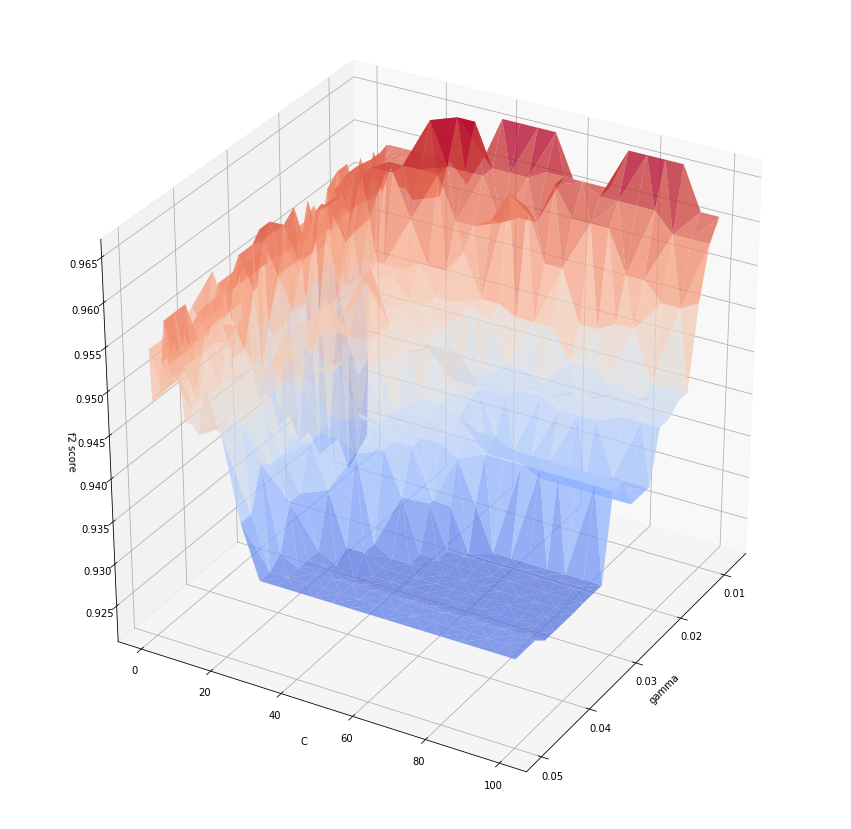

In [30]:
# Plot the surface for f2 score
plt.figure(figsize = (15, 15))
ax = plt.axes(projection='3d')
ax.plot_trisurf(results2.gamma, results2.C, results2.mean_test_f2, 
                cmap = cm.coolwarm, alpha = 0.75)
ax.set_xlabel('gamma')
ax.set_ylabel('C')
ax.set_zlabel('f2 score')
ax.view_init(azim=30)    # rotation
plt.show()

The above graph shows a hypeparameter space where the combos will perform quite well in SVM model according to what we have observed before. The surface bumpy, but it seems that a C near 10 and a gamma near 0.01 will give the best results. This will be confirmed below when we use the best combo we found.

In [31]:
# We use the best one for f2:
print(results_all_sorted2.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf2 = svm.SVC(C = results_all_sorted2.loc[0, 'C'], 
                     gamma = results_all_sorted2.loc[0, 'gamma'],
                     kernel = results_all_sorted2.loc[0, 'kernel'])
                     #random_state = 0)
svm_bestf2.fit(X_train, y_train)

y_train_pred = svm_bestf2.predict(X_train)
y_test_pred = svm_bestf2.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f2_train = f2_scorer(y_train, y_train_pred)
f2_test = f2_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f2 score of training sample: ', f2_train)
print('f2 score of test sample: ', f2_test)

C             10
gamma        NaN
kernel    linear
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[169   3]
 [  0 283]]
Confusion matrix of test sample: 
 [[39  1]
 [ 3 71]]
f2 score of training sample:  0.9859976662777129
f2 score of test sample:  0.9653465346534654


In [32]:
# We use the best one for f0.5:
print(results_all_sorted05.loc[0, ['C', 'gamma', 'kernel']])
svm_bestf05 = svm.SVC(C = results_all_sorted05.loc[0, 'C'], 
                      gamma = results_all_sorted05.loc[0, 'gamma'],
                      kernel = results_all_sorted05.loc[0, 'kernel'],
                      random_state = 0)
svm_bestf05.fit(X_train, y_train)

y_train_pred = svm_bestf05.predict(X_train)
y_test_pred = svm_bestf05.predict(X_test)

conf_mat_train = confusion_matrix(y_train, y_train_pred)
conf_mat_test = confusion_matrix(y_test, y_test_pred)

f05_train = f05_scorer(y_train, y_train_pred)
f05_test = f05_scorer(y_test, y_test_pred)

print('Confusion matrix of training sample: \n', conf_mat_train)
print('Confusion matrix of test sample: \n', conf_mat_test)
print('f0.5 score of training sample: ', f05_train)
print('f0.5 score of test sample: ', f05_test)

C              1
gamma        NaN
kernel    linear
Name: 0, dtype: object
Confusion matrix of training sample: 
 [[169   3]
 [  1 282]]
Confusion matrix of test sample: 
 [[38  2]
 [ 1 73]]
f0.5 score of training sample:  0.9917840375586855
f0.5 score of test sample:  0.9693877551020408


We get pretty descent results from both, and they produce the almost same confusion matrix. Given the simplicity of the data set and the feature of f score itself (balanced recall and precision), there is no much difference between those two objects here: maximizing f2 or f0.5.

In [33]:
print('It takes ' + str(round(time.time() - begin, 4)) + ' seconds to run.')

It takes 88.9135 seconds to run.
